### Turing.ml example: https://turing.ml/dev/tutorials/10-bayesian-differential-equations/ 

In [ ]:
using Turing, Distributions, DifferentialEquations

# Import MCMCChain, Plots, and StatsPlots for visualizations and diagnostics.
using MCMCChains, Plots, StatsPlots

# Set a seed for reproducibility.
using Random
Random.seed!(14);

In [ ]:
function lotka_volterra(du,u,p,t)
    x, y = u
    α, β, γ, δ  = p
    du[1] = (α - β*y)x # dx =
    du[2] = (δ*x - γ)y # dy =
end
p = [1.5, 1.0, 3.0, 1.0]
u0 = [1.0,1.0]
prob1 = ODEProblem(lotka_volterra,u0,(0.0,10.0),p)
sol = solve(prob1,Tsit5())
plot(sol)

sol1 = solve(prob1,Tsit5(),saveat=0.1)
odedata = Array(sol1) + 0.8 * randn(size(Array(sol1)))
plot(sol1, alpha = 0.3, legend = false); scatter!(sol1.t, odedata')

In [ ]:
Turing.setadbackend(:forwarddiff)

@model function fitlv(data, prob1)
    σ ~ InverseGamma(2, 3) # ~ is the tilde character
    α ~ truncated(Normal(1.5,0.5),0.5,2.5)
    β ~ truncated(Normal(1.2,0.5),0,2)
    γ ~ truncated(Normal(3.0,0.5),1,4)
    δ ~ truncated(Normal(1.0,0.5),0,2)

    p = [α,β,γ,δ]
    prob = remake(prob1, p=p)
    predicted = solve(prob,Tsit5(),saveat=0.1)

    for i = 1:length(predicted)
        data[:,i] ~ MvNormal(predicted[i], σ)
    end
end

model = fitlv(odedata, prob1)

# This next command runs 3 independent chains without using multithreading.
chain = mapreduce(c -> sample(model, NUTS(.65),1000), chainscat, 1:3)
plot(chain)

In [ ]:
pl = scatter(sol1.t, odedata');
chain_array = Array(chain)
for k in 1:300
    resol = solve(remake(prob1,p=chain_array[rand(1:1500), 1:4]),Tsit5(),saveat=0.1)
    plot!(resol, alpha=0.1, color = "#BBBBBB", legend = false)
end
# display(pl)
plot!(sol1, w=1, legend = false)

### simple reaction ODE


In [ ]:
using Turing, Distributions, DifferentialEquations

# Import MCMCChain, Plots, and StatsPlots for visualizations and diagnostics.
using MCMCChains, Plots, StatsPlots

# Set a seed for reproducibility.
using Random
Random.seed!(14);

function rxn(du, u, p, t)
    v = 0.0001
    OF = u[1]
    H_out = u[2]
    OFHb = u[3]
    k_on = 10^p[1]
    k_off = 10^p[2]
    du[1] = v*((OFHb*k_off) - (OF*H_out*k_on))
    du[2] = v*((OFHb*k_off) - (OF*H_out*k_on))
    du[3] = v*((OF*H_out*k_on) - (OFHb*k_off)) 
end


p = [6,2]  # log10 rates
u0 = [1.0,1.0, 0.0]
tspan = (0.0,1.0)
prob1 = ODEProblem(rxn,u0,tspan,p)
condition(u,t,integrator) = t==0.5
affect!(integrator) = integrator.u[1] = u0[1]
cb1 = DiscreteCallback(condition,affect!)

sol1 = solve(prob1,AutoTsit5(Rosenbrock23()),callback=cb1,tstops=[0.5])
odedata = Array(sol1) + 0.01 * randn(size(Array(sol1)))
# plot(sol1, alpha = 0.3, legend = false); scatter!(sol1.t, odedata')

plot(sol1, alpha = 0.8, legend = true)


#### Sampling and analysis

In [ ]:
Turing.setadbackend(:forwarddiff)

@model function fitlv(data, prob1)
    σ ~ Uniform(0.05, 0.5) # ~ is the tilde character
    log_k_on ~ Uniform(5,8)
    log_k_off ~ Uniform(1,4)

    p = [σ,log_k_on,log_k_off]
    prob = remake(prob1, p=p)
    condition(u,t,integrator) = t==0.5
    affect!(integrator) = integrator.u[1] = 1
    cb = DiscreteCallback(condition,affect!)

    predicted = solve(prob1,AutoTsit5(Rosenbrock23()),callback=cb1,tstops=[0.5])

    for i = 1:length(predicted)
        data[:,i] ~ MvNormal(predicted[i], σ)
    end
end

model = fitlv(odedata, prob1)

# This next command runs 3 independent chains without using multithreading.
chain = mapreduce(c -> sample(model, NUTS(.65),10000), chainscat, 1:3)
plot(chain)

In [ ]:
pl = scatter(sol1.t, odedata');

chain_array = Array(chain)
for k in 1:10
    prob = remake(prob1, p=chain_array[rand(1:1500), 1:2])
    condition(u,t,integrator) = t==0.5
    affect!(integrator) = integrator.u[1] = 1
    cb = DiscreteCallback(condition,affect!)
    predicted2 = solve(prob1,AutoTsit5(Rosenbrock23()),callback=cb1,tstops=[0.5])
    plot!(predicted2, alpha=0.1, color = "#BBBBBB", legend = false)
end
# display(pl)
plot!(sol1, w=1, legend = false)

### Single cycle transporter ODEs

In [ ]:
using Turing, Distributions, DifferentialEquations, Sundials, Noise, BenchmarkTools

# Import MCMCChain, Plots, and StatsPlots for visualizations and diagnostics.
using MCMCChains, Plots, StatsPlots

# Set a seed for reproducibility.
using Random
Random.seed!(14);


function transporter_s1(du, u, p, t)
    ### compartment size 
    #vol = 0.0001
    vol=1

    ### model parameters - reaction rate constants (in 1/s and 1/(Ms))
    rxn1_k1 = 0.0
    rxn1_k2 = 0.0
    rxn2_k1 = 10.0^p[1]  # H on rate
    rxn2_k2 = 10.0^p[2]  # H off rate
    rxn3_k1 = 10.0^p[3]  # S off rate
    rxn3_k2 = 10.0^p[4]  # S on rate
    rxn4_k1 = 10.0^p[5]  # conf rate
    rxn4_k2 = 10.0^p[6]  # conf rate
    rxn5_k1 = 0.0
    rxn5_k2 = 0.0
    rxn6_k1 = 10.0^p[7]  # conf rate
    rxn6_k2 = 10.0^p[8]  # conf rate
    rxn7_k1 = 0.0
    rxn7_k2 = 0.0
    rxn8_k1 = 0.0
    rxn8_k2 = 0.0
    rxn9_k1 = 0.0
    rxn9_k2 = 0.0
    rxn10_k1 = 0.0
    rxn10_k2 = 0.0
    rxn11_k1 = 10^p[9]  # S on rate
    rxn11_k2 = 10^p[10]  # S off rate
    rxn12_k1 = 10^p[11]  # H off rate
    rxn12_k2 = (rxn2_k1*rxn3_k1*rxn4_k1*rxn6_k1*rxn11_k1*rxn12_k1)/(rxn2_k2*rxn3_k2*rxn4_k2*rxn6_k2*rxn11_k2)  # H on rate (cycle constraint)
  
    ### model state concentrations (in M)
    # H_out = 1e-7  # constant external ion concentration (e.g. buffer solution) 
    H_out = p[12]
    S_out = 0.001  # constant external substrate concentration (e.g. buffer solution) 
    
    H_in = u[1]  # internal ion concentration
    S_in = u[2]  # internal substrate concentation
    OF = u[3]  # fully unbound outward-facing transporter 
    IF = u[4]  # fully unbound inward-facing transporter
    OF_Hb = u[5]  # ion-bound only outward-facing transporter
    IF_Hb = u[6]  # ion-bound only inward-facing transporter
    OF_Sb = u[7]  # substrate-bound only outward-facing transporter
    IF_Sb = u[8]  # substrate-bound only inward-facing transporter
    OF_Hb_Sb = u[9]  # ion and substrate bound outward-facing transporter
    IF_Hb_Sb = u[10]  # ion and substrate bound inward-facing transporter

    ### reaction equations (from Tellurium)       
    vrxn1 = vol*(rxn1_k1*IF-rxn1_k2*OF)
    vrxn2 = vol*(rxn2_k1*OF*H_out-rxn2_k2*OF_Hb)
    vrxn3 = vol*(rxn3_k1*OF_Sb-rxn3_k2*OF*S_out)
    vrxn4 = vol*(rxn4_k1*OF_Hb-rxn4_k2*IF_Hb)
    vrxn5 = vol*(rxn5_k1*OF_Hb_Sb-rxn5_k2*OF_Hb*S_out)
    vrxn6 = vol*(rxn6_k1*IF_Sb-rxn6_k2*OF_Sb)
    vrxn7 = vol*(rxn7_k1*OF_Sb*H_out-rxn7_k2*OF_Hb_Sb)
    vrxn8 = vol*(rxn8_k1*OF_Hb_Sb-rxn8_k2*IF_Hb_Sb)
    vrxn9 = vol*(rxn9_k1*IF_Hb-rxn9_k2*IF*H_in)
    vrxn10 = vol*(rxn10_k1*IF*S_in-rxn10_k2*IF_Sb)
    vrxn11 = vol*(rxn11_k1*IF_Hb*S_in-rxn11_k2*IF_Hb_Sb)
    vrxn12 = vol*(rxn12_k1*IF_Hb_Sb-rxn12_k2*IF_Sb*H_in)

    ### ODE equations (from Tellurium)
    du[1] = vrxn9 + vrxn12  #H_in
    du[2] = -vrxn10 - vrxn11  #S_in
    du[3] = vrxn1 - vrxn2 + vrxn3  #OF
    du[4] = -vrxn1 + vrxn9 - vrxn10  #IF
    du[5] = vrxn2 - vrxn4 + vrxn5  #OF_Hb
    du[6] = vrxn4 - vrxn9 - vrxn11  #IF_Hb   
    du[7] = -vrxn3 + vrxn6 - vrxn7  #OF_Sb
    du[8] = -vrxn6 + vrxn10 + vrxn12  #IF_Sb
    du[9] = -vrxn5 + vrxn7 - vrxn8 #OF_Hb_Sb
    du[10] = vrxn8 + vrxn11 - vrxn12  #IF_Hb_Sb
end 

### H buffer (external) concentrations - changed during experiment
H_out_conc = 1e-7

### rate constants
k_H_on = 1e10
k_H_off = 1e3
k_S_on = 1e7
k_S_off = 1e3
k_conf = 1e2
log_k_H_on = log10(k_H_on)
log_k_H_off = log10(k_H_off)
log_k_S_on = log10(k_S_on)
log_k_S_off = log10(k_S_off)
log_k_conf = log10(k_conf)

p = [
    log_k_H_on,
    log_k_H_off,
    log_k_S_off,
    log_k_S_on,
    log_k_conf,
    log_k_conf,
    log_k_conf,
    log_k_conf,
    log_k_S_on,  
    log_k_S_off,  
    log_k_H_off,
    H_out_conc,  
]
std_true = 1e-13 

### initial parameters
u0 = [
    1e-7,
    1e-3,
    2.833e-08,
    2.125e-08,
    2.833e-08,
    2.833e-08,
    2.125e-08,
    2.125e-08,
    2.125e-08,
    2.833e-08,
]
tspan = (0.0,10.0);

### make ODEProblem w/ timed events
prob = ODEProblem(transporter_s1,u0,tspan,p);
event_times = 5.0
condition(u,t,integrator) = t ∈ event_times
affect!(integrator) = integrator.p[12] = 5e-8
cb = DiscreteCallback(condition,affect!)

### solve ODE problem
#@btime sol = solve(prob, AutoTsit5(Rosenbrock23()), saveat=0.01, abstol = 1e-19, reltol = 1e-17, progress=true, callback=cb, tstops=[5.0]);
sol = solve(prob, TRBDF2(), abstol = 1e-14, reltol = 1e-6, saveat=0.04, progress=false, callback=cb, tstops=[5.0]);
# abstol = 1e-14, reltol = 1e-6
### flux calculation
#vol_tmp = 0.0001
vol_tmp = 0.0001
IF_Hb_Sb_tmp = sol[10,:]
IF_Sb_tmp = sol[8,:]
H_in_tmp = sol[1,:]
rxn12_k1_tmp = 10^log_k_H_off
rxn12_k2_tmp = 10^((p[1]+p[3]+p[5]+p[7]+p[9]+p[11])-(p[2]+p[4]+p[6]+p[8]+p[10]))
x1 = rxn12_k1_tmp*IF_Hb_Sb_tmp
x2 = rxn12_k2_tmp*IF_Sb_tmp.*H_in_tmp
y_true = vol_tmp*(x1-x2)
y_obs = add_gauss(y_true,std_true)
plot(y_true, alpha = 0.8, legend = false, ylim=[-1.5e-11,1.5e-11])#;scatter!(y_obs)

#### sampling

In [ ]:
using LinearAlgebra
LinearAlgebra.BLAS.set_num_threads(12)
using Random
Random.seed!(14);
# using MKL


# using ReverseDiff
Turing.setadbackend(:forwarddiff)
# using Memoization
# Turing.setrdcache(true)
std_true = 1e-13 

@model function transporter_sampler(data, prob1)
    std_sample ~ Uniform(0.5e-13 , 1.5e-13) # ~ is the tilde character
    log_rxn2_k1 ~ Uniform(6,12)  # H on rate (1e10)
    log_rxn2_k2 ~ Uniform(-1,5)  # H off rate (1e3)
    log_rxn3_k1 ~ Uniform(-1,5)  # S off rate (1e3)
    log_rxn3_k2 ~ Uniform(3,9)  # S on rate (1e7)
    log_rxn4_k1 ~ Uniform(-2,4)  # conf rate (1e2)
    log_rxn4_k2 ~ Uniform(-2,4)   # conf rate (1e2)
    log_rxn6_k1 ~ Uniform(-2,4)   # conf rate (1e2)
    log_rxn6_k2 ~ Uniform(-2,4)   # conf rate (1e2)
    log_rxn11_k1 ~ Uniform(3,9) # S on rate (1e7)
    log_rxn11_k2 ~ Uniform(-1,5)  # S off rate (1e3)
    log_rxn12_k1 ~ Uniform(-1,5)  # H off rate (1e3)
    
    #println(std_sample)
    
    H_out_conc1 = 1e-7
    p1 = [
        log_rxn2_k1,
        log_rxn2_k2,
        log_rxn3_k1,
        log_rxn3_k2,
        log_rxn4_k1,
        log_rxn4_k2, 
        log_rxn6_k1,
        log_rxn6_k2, 
        log_rxn11_k1,
        log_rxn11_k2,
        log_rxn12_k1,
        H_out_conc1,
    ]

    ### initial parameters
    u0 = [
        1e-7,
        1e-3,
        2.833e-08,
        2.125e-08,
        2.833e-08,
        2.833e-08,
        2.125e-08,
        2.125e-08,
        2.125e-08,
        2.833e-08,
    ]

    tspan = (0.0,10.0);
    prob_sample = ODEProblem(transporter_s1,u0,tspan,p1);
    event_times1 = 5.0
    condition(u,t,integrator) = t ∈ event_times1
    affect!(integrator) = integrator.p[12] = 5e-8
    cb1 = DiscreteCallback(condition,affect!)
    #sol1 = solve(prob_sample, alg_hints=[:stiff], saveat=0.04, abstol = 1e-16, reltol = 1e-14, progress=true, callback=cb1, tstops=[5.0]);
    sol1 = solve(prob_sample,  TRBDF2(), abstol = 1e-14, reltol = 1e-6, saveat=0.04, progress=false, callback=cb1, tstops=[5.0]);
    
    # flux calc
    vol_tmp1 = 0.0001
    IF_Hb_Sb_tmp1 = sol1[10,:]
    IF_Sb_tmp1 = sol1[8,:]
    H_in_tmp1 = sol1[1,:]
    rxn12_k1_tmp1 = 10^log_rxn12_k1
    rxn12_k2_tmp1 = 10^((p1[1]+p1[3]+p1[5]+p1[7]+p1[9]+p1[11])-(p1[2]+p1[4]+p1[6]+p1[8]+p1[10]))

    x11 = rxn12_k1_tmp1*IF_Hb_Sb_tmp1
    x21 = rxn12_k2_tmp1*IF_Sb_tmp1.*H_in_tmp1

    y_pred = vol_tmp1*(x11-x21)

    
    for i = 1:length(y_pred)
        data[i] ~ Normal(y_pred[i], std_sample)
    end
    
end

model = transporter_sampler(y_obs, prob)

# This next command runs 3 independent chains without using multithreading.
#chain = mapreduce(c -> sample(model, NUTS(100, .65),100), chainscat, 1:3)
c = sample(model, NUTS(1000, .65),1000);

In [ ]:
c

In [ ]:
c[:std_sample]

In [ ]:
plot(c)

In [ ]:
png("test")

In [ ]:
import DataFrame, CSV
df = Dataframe(c)
CSV.write("test.csv", df)
df2 = CSV.read("test.csv")

In [ ]:
using Turing, Distributions, DifferentialEquations, Random, Noise

Random.seed!(14

Turing.setadbackend(:forwarddiff)
# using Memoization
# Turing.setrdcache(true)


for i in 1:10
    x ~ Uniform(0.5e-13 , 1.5e-13) # ~ is the tilde character
    println(x)
end  

In [ ]:
df = CSV.read("test.csv", DataFrame)


In [ ]:
using Catalyst, DifferentialEquations, StatsPlots, Plots, DataFrames, CSV, Random, Turing, Latexify, ModelingToolkit, DynamicHMC
using ModelingToolkit: varmap_to_vars
Random.seed!(14)

# load flux dataset fo ~ 300 data points
df = CSV.read("data_1c.csv", DataFrame) 
y_obs = df[!, "data"]

# flux calculation function
function calc_flux(p,u,v)
    flux_in = v*(p[1]*u[1])
    flux_out = v*(p[2]*u[2].*u[3])
    net_flux = flux_in - flux_out         
end

# define reaction network in Catalyst
rn = @reaction_network begin
  (k1_f*H_out, k1_r), OF <--> OF_Hb
  (k2_f, k2_r), OF_Hb <--> IF_Hb
  (k3_f, k3_r), IF_Hb + S_in <--> IF_Hb_Sb
  (k4_f, k4_r), IF_Hb_Sb <--> IF_Sb + H_in
  (k5_f, k5_r), IF_Sb <--> OF_Sb
  (k6_f, k6_r*S_out), OF_Sb <--> OF
end H_out S_out k1_f k1_r k2_f k2_r k3_f k3_r k4_f k4_r k5_f k5_r k6_f k6_r
@parameters  H_out S_out k1_f k1_r k2_f k2_r k3_f k3_r k4_f k4_r k5_f k5_r k6_f k6_r 
@variables t H_in(t) S_in(t) OF(t) OF_Hb(t) IF_Hb(t) IF_Hb_Sb(t) IF_Sb(t) OF_Sb(t)
u0map = [H_in => 1e-7, S_in => 1e-3, 
        OF => 2.833e-8, OF_Hb => 2.833e-8,  
        IF_Hb => 2.833e-8, IF_Hb_Sb => 2.833e-8,
        IF_Sb => 2.125e-8, OF_Sb => 2.125e-8, 
        ]
H_out_ref = 1e-7
S_out_ref = 1e-3
pmap = [H_out => H_out_ref, S_out => S_out_ref,
        k1_f =>1e10, k1_r =>1e3,
        k2_f =>1e2, k2_r =>1e2,
        k3_f =>1e7, k3_r =>1e3,
        k4_f =>1e3, k4_r =>1e10,
        k5_f =>1e2, k5_r =>1e2,
        k6_f =>1e3, k6_r =>1e7
        ]

# convert reaction network to ODEsystem
odesys = convert(ODESystem, rn)
latexify(odesys)

In [ ]:
using StructuralIdentifiability, ModelingToolkit
test_ode = @ODEmodel( 
    OF'(t) = k1_r*OF_Hb(t)+k6_f*OF_Sb(t)−H_out*k1_f*OF(t)−S_out*k6_r*OF(t),
    OF_Hb'(t) = k2_r*IF_Hb(t)+H_out*k1_f*OF(t)−k1_r*OF_Hb(t)−k2_f*OF_Hb(t),
    IF_Hb'(t) = k3_r*IF_Hb_Sb(t)+k2_f*OF_Hb(t)−k2_r*IF_Hb(t)−k3_f*IF_Hb(t)*S_in(t),
    S_in'(t) = k3_r*IF_Hb_Sb(t)−k3_f*IF_Hb(t)*S_in(t),
    IF_Hb_Sb'(t) = −k3_r*IF_Hb_Sb(t)−k4_f*IF_Hb_Sb(t)+k3_f*IF_Hb(t)*S_in(t)+k4_r*H_in(t)*IF_Sb(t),
    IF_Sb'(t) = k4_f*IF_Hb_Sb(t)+k5_r*OF_Sb(t)−k5_f*IF_Sb(t)−k4_r*H_in(t)*IF_Sb(t),
    H_in'(t) = k4_f*IF_Hb_Sb(t)−k4_r*H_in(t)*IF_Sb(t),
    OF_Sb'(t) = k5_f*IF_Sb(t)+S_out*k6_r*OF(t)−k5_r*OF_Sb(t)−k6_f*OF_Sb(t),
    y1(t) = H_out, 
    y2(t) = S_out, 
    y3(t) = H_in'(t)
)

@time global_id = assess_local_identifiability(test_ode,0.999, :SE)
println(global_id)


In [ ]:
@time global_id = assess_identifiability(test_ode, 0.80)

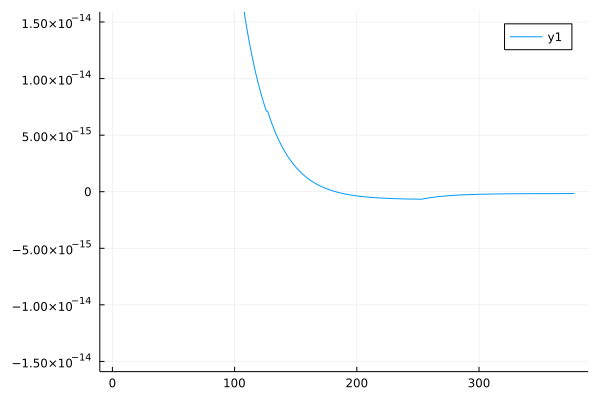

In [14]:
using Catalyst, DifferentialEquations, StatsPlots, Plots, DataFrames, CSV, Random, Turing, Latexify, ModelingToolkit, DynamicHMC
using ModelingToolkit: varmap_to_vars
Random.seed!(14)

# load flux dataset fo ~ 300 data points
df = CSV.read("data_1c.csv", DataFrame) 
y_obs = df[!, "data"]

# flux calculation function
function calc_flux(p,u,v)
    flux_in = v*(p[1]*u[1])
    flux_out = v*(p[2]*u[2].*u[3])
    net_flux = flux_in - flux_out         
end

# define reaction network in Catalyst
rn = @reaction_network begin
  (k1_f*H_out, k1_r), OF <--> OF_Hb
  (k2_f, k2_r), OF_Hb <--> IF_Hb
  (k3_f, k3_r), IF_Hb + S_in <--> IF_Hb_Sb
  (k4_f, k4_r), IF_Hb_Sb <--> IF_Sb + H_in
  (k5_f, k5_r), IF_Sb <--> OF_Sb
  (k6_f, k6_r*S_out), OF_Sb <--> OF
end H_out S_out k1_f k1_r k2_f k2_r k3_f k3_r k4_f k4_r k5_f k5_r k6_f k6_r
@parameters  H_out S_out k1_f k1_r k2_f k2_r k3_f k3_r k4_f k4_r k5_f k5_r k6_f k6_r 
@variables t H_in(t) S_in(t) OF(t) OF_Hb(t) IF_Hb(t) IF_Hb_Sb(t) IF_Sb(t) OF_Sb(t)
u0map = [H_in => 1e-7, S_in => 1e-3, 
        OF => 2.833e-8, OF_Hb => 2.833e-8,  
        IF_Hb => 2.833e-8, IF_Hb_Sb => 2.833e-8,
        IF_Sb => 2.125e-8, OF_Sb => 2.125e-8, 
        ]
H_out_ref = 1e-7
S_out_ref = 1e-3





pmap = [H_out => H_out_ref, S_out => S_out_ref,
        k1_f =>1e10, k1_r =>1e3,
        k2_f =>1e2, k2_r =>1e2,
        k3_f =>1e7, k3_r =>1e3,
        k4_f =>1e3, k4_r =>1e10,
        k5_f =>1e2, k5_r =>1e2,
        k6_f =>1e3, k6_r =>1e7
        ]

pmap_NUTS = [H_out => H_out_ref, S_out => S_out_ref,
        k1_f =>10^8.2036, k1_r =>10^3.8007 ,
        k2_f =>10^2.2226, k2_r =>10^-0.0250,
        k3_f =>10^6.2090, k3_r =>10^4.0159,
        k4_f =>10^0.3333, k4_r =>10^6.9545,
        k5_f =>10^2.9389, k5_r =>10^-1.0437,
        k6_f =>10^1.6870, k6_r =>10^((8.2036+2.2226+6.2090+0.3333+2.9389+1.6870)-(3.8007+-0.0250+4.0159+6.9545+-1.0437))
        ]

pmap_MC = [H_out => H_out_ref, S_out => S_out_ref,
        k1_f =>10^9.8120, k1_r =>10^3.0432,
        k2_f =>10^3.1035, k2_r =>10^2.5459,
        k3_f =>10^7.7993, k3_r =>10^2.5234,
        k4_f =>10^2.4692, k4_r =>10^8.1623,
        k5_f =>10^3.0059, k5_r =>10^3.0956,
        k6_f =>10^0.7882, k6_r =>10^((9.8120+3.1035+7.7993+2.4692+3.0059+0.7882)-(3.0432+2.5459+2.5234+8.1623+3.0956))
        ]

# convert reaction network to ODEsystem
odesys = convert(ODESystem, rn)
latexify(odesys)


# create ODEproblem w/ timed events discrete callback
tspan1 = (0.0,15.0)
oprob = ODEProblem(odesys, u0map, tspan1, pmap_NUTS)
event_times = [5.0,10]
condition(u,t,integrator) = t ∈ event_times
function affect!(integrator)
    if integrator.t == 5.0
        integrator.p[1] = 5e-8
    elseif integrator.t == 10.0
        integrator.p[1] = 1e-7
    end
end
cb = DiscreteCallback(condition,affect!)

sol = solve(oprob, TRBDF2(), abstol = 1e-18, reltol = 1e-16, saveat=0.04, callback=cb, tstops=[5.0, 10.0])

k = [pmap_NUTS[9][2], pmap_NUTS[10][2]]
c = [sol[IF_Hb_Sb], sol[H_in], sol[IF_Sb]]
vol = 0.0001
y_pred = calc_flux(k,c,vol)
#plot(y_pred, legend = true, ylim=[-1.5e-11,1.5e-11]);scatter!(y_obs, alpha=0.75)
plot(y_pred, legend = true, ylim=[-1.5e-14,1.5e-14])